In [1]:
%matplotlib notebook

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.losses import categorical_crossentropy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

import sys
sys.path
sys.path.append("../../models/classification")

from models import ResNet, AlexNet
from dataset import Dataset

In [2]:
TRAIN_PATH = "../../../honours_project_data/main/train_high.txt"
VAL_PATH = "../../../honours_project_data/main/test_high.txt"

train_data = Dataset(TRAIN_PATH, res=(120, 160))
val_data = Dataset(VAL_PATH, res=(120, 160))
X, y = val_data.get_all()

In [3]:
VIS_WEIGHTS_PATH = "../../../out/new_out/ResNet/ResNet_rgb_weights.h5"
LWIR_WEIGHTS_PATH = "../../../out/new_out/ResNet/ResNet_lwir_weights.h5"
FUSION_WEIGHTS_PATH = "../../../out/new_out/ResNet/ResNet_fusion_weights.h5"

model_rgb = ResNet("rgb", train_data.num_classes(), train_data.shape()).get_model()
model_lwir = ResNet("lwir", train_data.num_classes(), train_data.shape()).get_model()
model_fusion = ResNet("fusion", train_data.num_classes(), train_data.shape()).get_model()

model_rgb.load_weights(VIS_WEIGHTS_PATH)
model_lwir.load_weights(LWIR_WEIGHTS_PATH)
model_fusion.load_weights(FUSION_WEIGHTS_PATH)

In [4]:
preds_rgb = model_rgb.predict(X)
preds_lwir = model_lwir.predict(X)
preds_fusion = model_fusion.predict(X)

scores = []
for img, label, rgb, lwir, fusion in zip(X, y, preds_rgb, preds_lwir, preds_fusion):
    mean_rgb = np.mean(img[..., :3])
    std_rgb = np.std(img[..., :3])
    mean_lwir = np.mean(img[..., 3])
    std_lwir = np.std(img[..., 3])
    
    loss_rgb = categorical_crossentropy(label, rgb)
    loss_lwir = categorical_crossentropy(label, lwir)
    loss_fusion = categorical_crossentropy(label, fusion)
    
    scores.append((mean_rgb, std_rgb, mean_lwir, std_lwir, loss_rgb, loss_lwir, loss_fusion))

scores = pd.DataFrame(np.array(scores), columns=["mean_rgb", "std_rgb", "mean_lwir", "std_lwir", "rgb", "lwir", "fusion"])

scores_mean_rgb = scores.groupby("mean_rgb").mean()
scores_std_rgb = scores.groupby("std_rgb").mean()
scores_mean_lwir = scores.groupby("mean_lwir").mean()
scores_std_lwir = scores.groupby("std_lwir").mean()

<IPython.core.display.Javascript object>


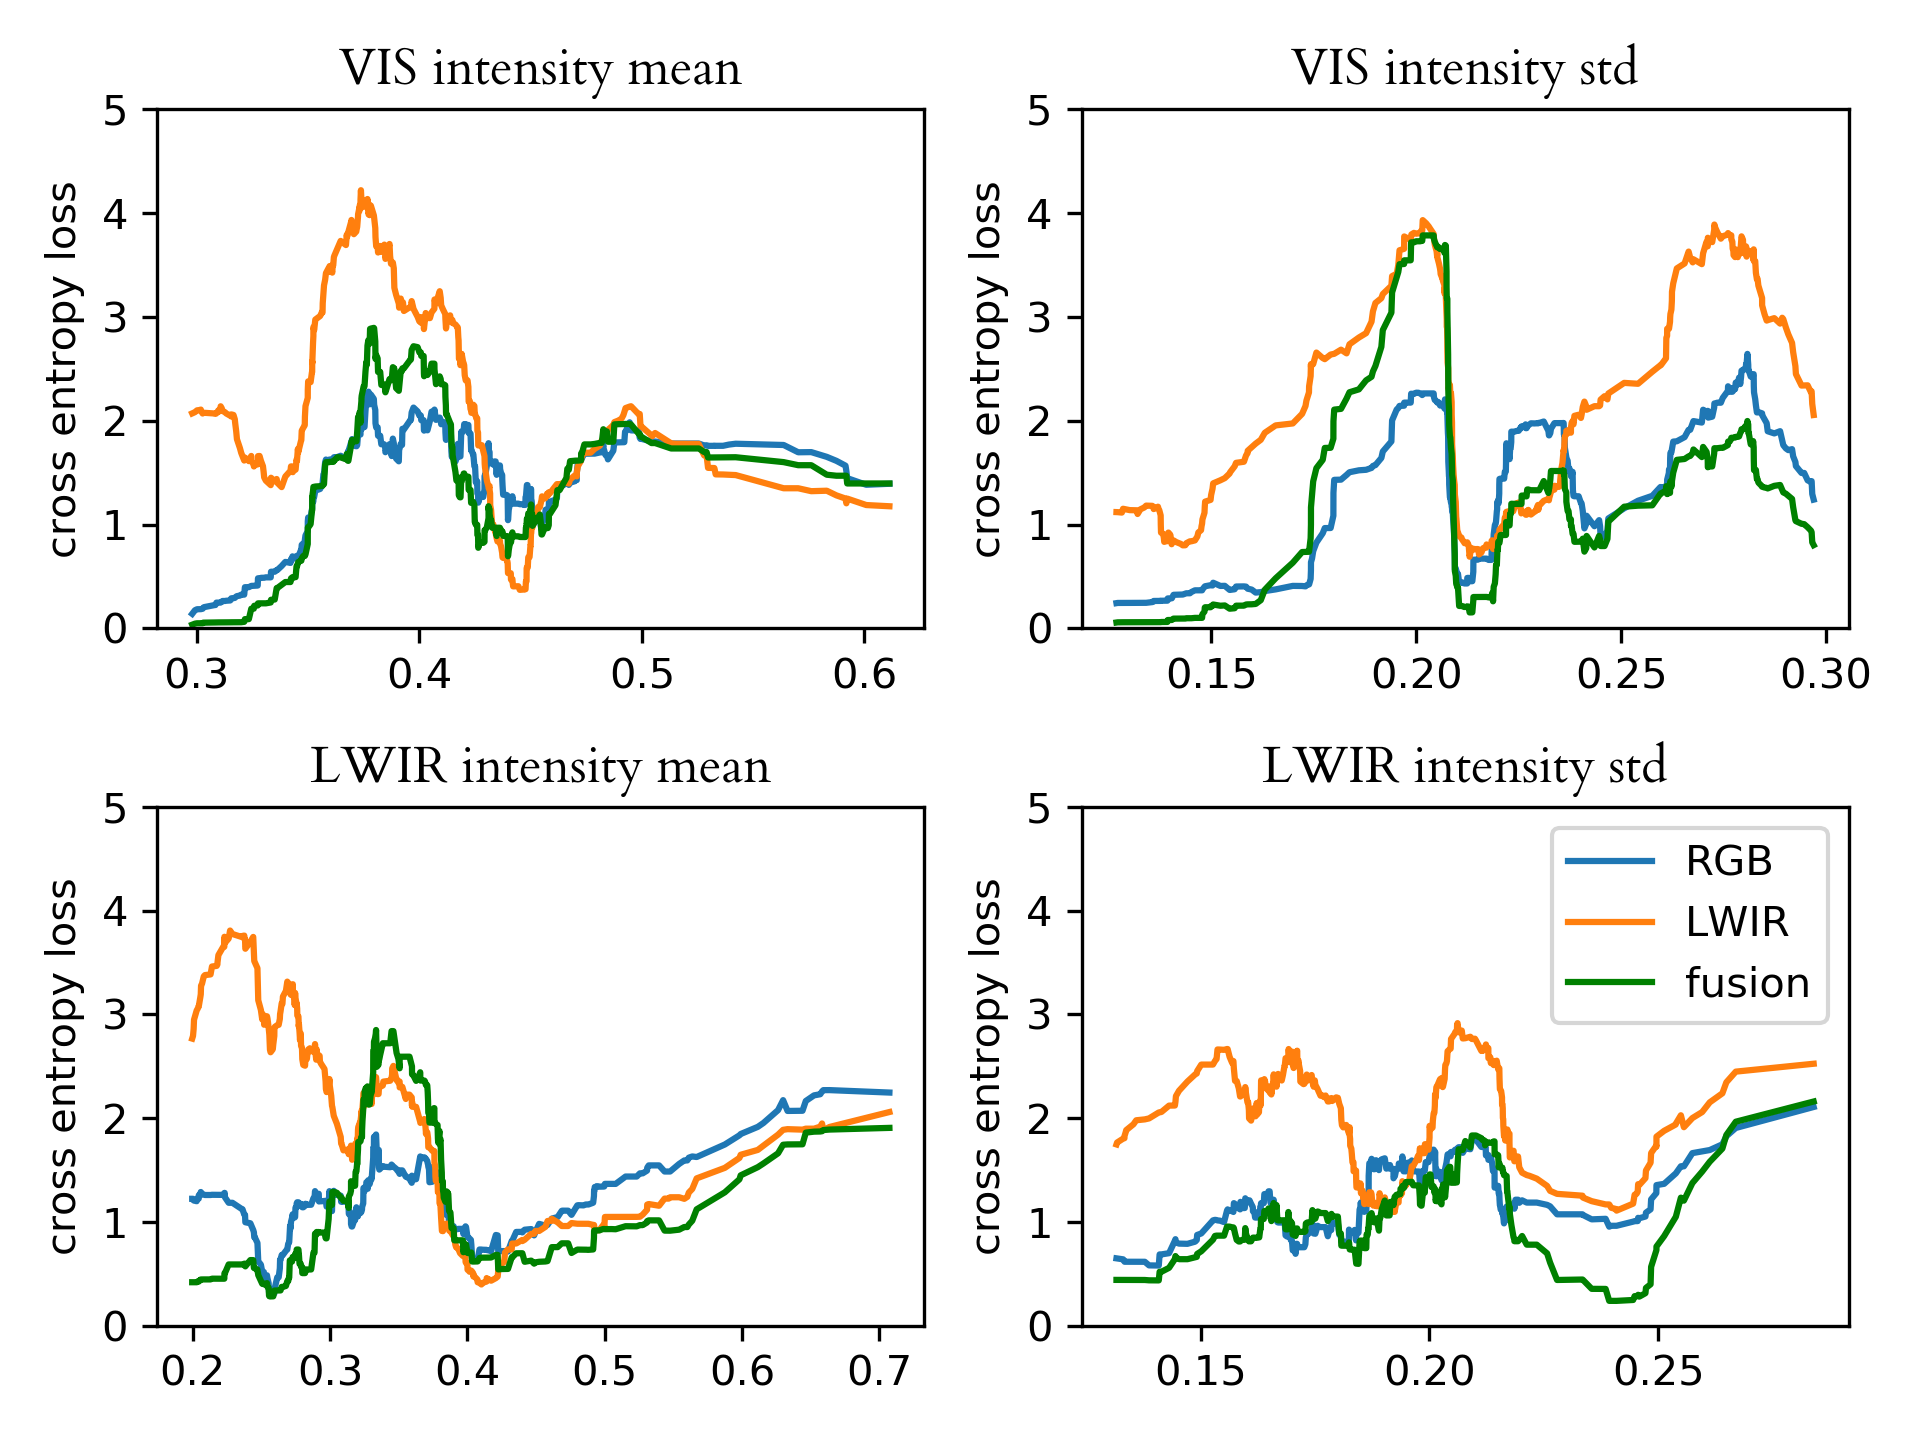

In [10]:
fig, ax = plt.subplots(2, 2, dpi=150)

font = {
    "fontname": "fbb",
    # "fontweight": "bold",
}

def plot_metric(ax, name, df, rolling_window=75, ylim=[0, 5], legend=False):
    ax.plot(df.index, df.rgb.rolling(rolling_window).mean(), label="RGB")
    ax.plot(df.index, df.lwir.rolling(rolling_window).mean(), label="LWIR")
    ax.plot(df.index, df.fusion.rolling(rolling_window).mean(), label="fusion", c="green")
    ax.set_ylabel("cross entropy loss")
    ax.set_ylim(ylim)
    ax.set_title(name, fontdict=font)
    if legend:
        ax.legend()

        
plot_metric(ax[0][0], "VIS intensity mean", scores_mean_rgb)
plot_metric(ax[0][1], "VIS intensity std", scores_std_rgb)
plot_metric(ax[1][0], "LWIR intensity mean", scores_mean_lwir)
plot_metric(ax[1][1], "LWIR intensity std", scores_std_lwir, legend=True)

fig.tight_layout()

In [12]:
plt.savefig("output.pdf")

'fbb-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
